# Train a neural network for the MNIST dataset using NumPy

## Setting up

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from utils import read_mnist, show
%matplotlib inline
import time
import itertools

In [2]:
# Load training data just for reference
X_train, Y_train = read_mnist('train')

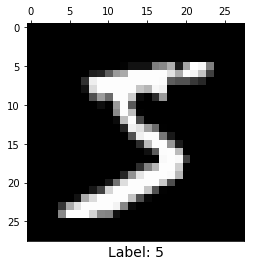

In [3]:
show(X_train[0], Y_train[0])

## Define the neural network

In [21]:
def neural_network_prediction(x, W, b):
    """This is the entire neural net!"""
    ##
    ## your function from the last notebook
    y_scores = x.T.dot(W) + b
    prediction = softmax(y_scores.flatten())
    return prediction

def softmax(z):
    """Return the softmax of vector z.

    The softmax returns normalized positive values.
    It is defined as softmax(z_i) = normalise(exp(z_i))
    = \\frac{exp(z_i)}{\sum_j exp(z_j)}.
    """
    z -= np.max(z)  # for numerical stability
    exps = np.exp(z)
    return np.divide(exps, np.sum(exps))

## Define a loss function for the network to minimise
Also sometimes called a cost function.

In [5]:
def cross_entropy_loss(p, q):
    """Return the cross-entropy of q with respect to p.

    The cross-entropy is a measure of how much distribution q
    diverges from distribution p. It is defined as
    H_p(q) = - \sum_x p(x) \log q(x).
    """
    return -np.sum(p * np.log(q))

## Encode true labels as vectors, consistent with predictions
The neural network takes a `28x28` pixel image (flattened to a vector of length 784) and outputs a prediction for digit shown in the image. The output is a vector of length ten, which forms a probability distribution over the possible classes `0-9` for the input image. Obviously the predicited class is just the class assigned the largest probability. 

But our loss function wants to compare distributions, and so expects vectors of equal length. Currently the true labels in the dataset are digits, `0`, or `1`, or ... `9`, not vectors. **Let's encode labels as a vector, such that `3` -> `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`**

In [6]:
def one_hot_encode(label):
    """One-hot encode a class label.

    Given a class label, return an array of length 10 with all
    elements zero, except for the element with index `label`,
    which is 1.0.
    """
    encoded = np.zeros(10)
    encoded[label] = 1.0
    return encoded

## Define the gradients of the loss function with reference to parameters
We 'learn' by updating the parameters W, b so as to minimise the loss function. This requires calculating the gradient of the loss function wrt the parameters.

In general, when we have many millions of parameters the 'backpropagation' algorithm allows us to do this efficiently: we compute partial derivatives and apply the chain rule as needed to avoid unecessary recomputing. For this simple network we don't even need to worry about backprop.

**Let's just code by hand the gradients for the loss with reference to W and b.**

_(We did the maths so you don't have to. Feel free to check it, but obviously in the future you won't be hardcoding derivatives)._

In [7]:
def dloss_dw(y_true, x, y_pred):
    """Analytic gradient of cross-entropy with reference to matrix W."""
    return np.outer(np.negative(x), y_true*(1-y_pred))


def dloss_db(y_true, x, y_pred):
    """Analytic gradient of cross-entropy with reference to vector b"""
    return np.negative(y_true)*(1-y_pred)

## Define the error rate
Just like before, we'll want to see how our network performs.

In [8]:
def error_rate_mnist(W, b, dataset='test'):
    """Calculate the error rate."""
    data_seen = 0.
    total_correct = 0.
    total_errors = 0.

    X, Y = read_mnist(dataset)
    for x, y in zip(X, Y):
        y_pred = np.argmax(neural_network_prediction(x, W, b))
        if y_pred == y:
            total_correct += 1
        else:
            total_errors += 1
        data_seen += 1

    return total_errors / data_seen

## Train the network
To learn the parameters, we i. loop through the data, ii. compute the performance of the network and iii. update the parameters accordingly... we also iv. print out some metrics to see how we're doing.

We provide you with the structure for a `learn` function your task is to make it work

In [25]:
def learn(W, b, max_iters=100000, learning_rate=0.01, batch_size=20):
    """Update W, b to reduce cross-entropy on using gradient descent."""
    W = W.copy()  # don't overwrite original parameters
    b = b.copy()
    grad_w = np.zeros(W.shape)  # initailise the gradients
    grad_b = np.zeros(b.shape)

    # keep track of some metrics
    total_loss = 0
    losses = []
    train_errors = []
    test_errors = []
    start = time.time()
    print_freq = max_iters / 10  # print progress 10 times during learning

    # learn by cycling repeatedly through data for max_iters iterations
    X_train, Y_train = read_mnist('train')
    
    for i, (x, label) in enumerate(itertools.cycle(zip(X_train, Y_train))):
        ## Task 1: generate prediction
        prediction = neural_network_prediction(x, W, b)
        ##
        ##
        ## Task 2: compute loss and gradients
        total_loss += cross_entropy_loss(one_hot_encode(label), prediction)
        grad_w += dloss_dw(one_hot_encode(label), x, prediction)
        grad_b += dloss_db(one_hot_encode(label), x, prediction)
        ##
        
        if i % batch_size == 0:
            ## Task 3: update parameters every batch_size iterations
            W -= learning_rate * grad_w / batch_size
            b -= learning_rate * grad_b / batch_size
            grad_w = np.zeros(W.shape)
            grad_b = np.zeros(b.shape)
            ##
            ##
            ##
            pass
            
        # print some metrics
        if i % print_freq == 0:
            total_loss /= print_freq
            train_error = error_rate_mnist(W, b, 'training')
            test_error = error_rate_mnist(W, b, 'validation')
            running_time = (time.time() - start)
            print(("Iteration {i} | Loss: {loss:.4f} | "
                   "Train error: {train:.4f} | Test error: {test:.4f} | "
                   "Total run time: {t:.1f}s".format(i=i,
                                                     loss=total_loss,
                                                     train=train_error,
                                                     test=test_error,
                                                     t=running_time)))
            # accumulate the metrics
            train_errors.append(train_error)
            test_errors.append(test_error)
            losses.append(total_loss)
            total_loss = 0
            

        if i > max_iters:
            return W, b, losses, train_errors, test_errors

In [26]:
## Task 4: randomly initialise parameters
W1 = np.random.random((784,10)) - 0.5
b1 = np.random.random((1,10)) -0.5

In [30]:
## Task 5: Train your network!
W,b, losses, train_errors, test_errors = learn(W1, b1, max_iters=100000, learning_rate=0.01, batch_size=20)

Iteration 0 | Loss: 0.0005 | Train error: 0.9017 | Test error: 0.8993 | Total run time: 11.4s
Iteration 10000 | Loss: 2.1392 | Train error: 0.4549 | Test error: 0.4318 | Total run time: 20.0s
Iteration 20000 | Loss: 1.2027 | Train error: 0.3405 | Test error: 0.3091 | Total run time: 31.4s
Iteration 30000 | Loss: 0.9175 | Train error: 0.2793 | Test error: 0.2456 | Total run time: 41.3s
Iteration 40000 | Loss: 0.8770 | Train error: 0.2422 | Test error: 0.2111 | Total run time: 50.6s
Iteration 50000 | Loss: 0.8102 | Train error: 0.2220 | Test error: 0.1889 | Total run time: 59.7s
Iteration 60000 | Loss: 0.7293 | Train error: 0.2036 | Test error: 0.1768 | Total run time: 69.4s
Iteration 70000 | Loss: 0.7570 | Train error: 0.2011 | Test error: 0.1753 | Total run time: 78.8s
Iteration 80000 | Loss: 0.7084 | Train error: 0.1906 | Test error: 0.1658 | Total run time: 87.8s
Iteration 90000 | Loss: 0.7659 | Train error: 0.1824 | Test error: 0.1580 | Total run time: 97.0s
Iteration 100000 | Loss:

In [31]:
def plot_learning(losses, train_errors, test_errors):
    '''Plot the train/test error rate and the loss'''
    fig, ax = plt.subplots(ncols=2, figsize=(14, 5), squeeze=True)

    ax[0].plot(range(len(train_errors)), train_errors, '-o', label='Training error')
    ax[0].plot(range(len(test_errors)),  test_errors, '-o', label='Test error')
    ax[0].set_ylim(0, 1)
    ax[0].legend(loc='upper right')
    ax[0].set_title('Error rate')

    ax[1].plot(range(len(losses)), losses, '-o')
    ax[1].set_title('Losses')
    plt.show()

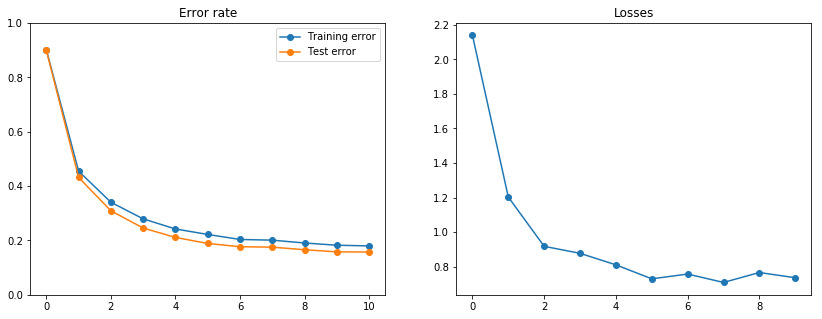

In [32]:
## Task 6: Plot the loss function and error rate over time
##
plot_learning(losses[1:], train_errors, test_errors)